# Bayesian Gaussian Mixture Model (for Unsupervised Learning) and Posterior Predictive Simulation
## 1. Model Setup
- Input data:
$X$ (data matrix, shape $n \times d$, where each row is a data point and each column is a feature)

- Assume a Gaussian mixture model with $K$ components (clusters):
For each data point $i$:
Assign a latent cluster label $z_i \in \{0, 1, \ldots, K-1\}$

The generative process:
$$
\begin{align*}
\pi &\sim \text{Dirichlet}(\alpha) \\
z_i &\sim \text{Categorical}(\pi) \\
\mu_k &\sim \mathcal{N}(0, 10^2) \\
\sigma_k &\sim \text{HalfNormal}(1) \\
x_i &\sim \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)
\end{align*}
$$
where:
- $\pi$ are the mixture weights (probabilities for each cluster)
- $z_i$ is the latent cluster assignment for data point $i$
- $\mu_k$ and $\sigma_k$ are the mean and standard deviation for cluster $k$
## 2. Priors
Mixture weights:
$$
\pi \sim \text{Dirichlet}(\alpha)
$$
Cluster assignments:
$$
z_i \sim \text{Categorical}(\pi)
$$
Cluster means:
$$
\mu_k \sim \mathcal{N}(0, 10^2)
$$
Cluster standard deviations:
$$
\sigma_k \sim \text{HalfNormal}(1)
$$

## 3. Likelihood
For each data point $i$:
$$
x_i \sim \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)
$$
where 
$z_i$ is the latent cluster assignment.
## 4. Posterior Sampling
Use MCMC (Markov Chain Monte Carlo) to sample from the posterior distribution of the parameters and latent variables:
$$
p(\pi, \{\mu_k\}, \{\sigma_k\}, \{z_i\} \mid X)
$$
This gives you many samples (draws) of all parameters and assignments that are plausible given the data and priors.
## 5. Posterior Predictive Simulation

For each posterior sample:

- Sample a cluster $z^∗ \sim \text{Categorical}(\pi)$
- Sample a new data point:
$$
x^* \sim \mathcal{N}(\mu_{z^*}, \sigma_{z^*}^2)
$$
Repeat for all posterior samples. 

The collection of $x^*$
  values form the posterior predictive distribution for new data points. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from scipy.stats import mode
import sys
sys.path.append('../src')
from bayesian_gaussian_mixture import bayesian_gaussian_mixture_clustering
from scipy.optimize import linear_sum_assignment
from scipy.stats import mode

# Iris dataset 
# ignore labels for unsupervised clustering
iris = load_iris()
X = iris.data  
y_true = iris.target 

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

In [2]:
# Fit Bayesian GMM 
# use 3 clusters
trace, cluster_assignments = bayesian_gaussian_mixture_clustering(
    X_2d, n_components=3, draws=500, tune=500, chains=3, random_seed=42
)

Sequential sampling (3 chains in 1 job)
CompoundStep
>NUTS: [pi, mus, sigmas]
>CategoricalGibbsMetropolis: [category]


Output()

Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# Flatten posterior params
mus = trace.posterior['mus'].values  
mus = mus.reshape(-1, *mus.shape[-2:])  
S, K, D = mus.shape

# Pick a reference cluster order using the first posterior sample’s means 
ref_order = np.argsort(mus[0, :, 0])
mus_ref = mus[0][ref_order]

# Best permutation for each sample to match reference
perms = []
for s in range(S):
    cost = np.linalg.norm(mus[s][:, None, :] - mus_ref[None, :, :], axis=2)  
    r, c = linear_sum_assignment(cost) 
    perm = np.argsort(c)  # reorder to reference order
    perms.append(perm)
perms = np.array(perms)  

# Align training latent assignments before taking mode
cats = cluster_assignments.reshape(-1, cluster_assignments.shape[-1])  
cats_aligned = np.empty_like(cats)
for s in range(S):
    cats_aligned[s] = np.take(perms[s], cats[s]) 

# Final aligned assignments on training data
final_assignments = mode(cats_aligned, axis=0, keepdims=False).mode

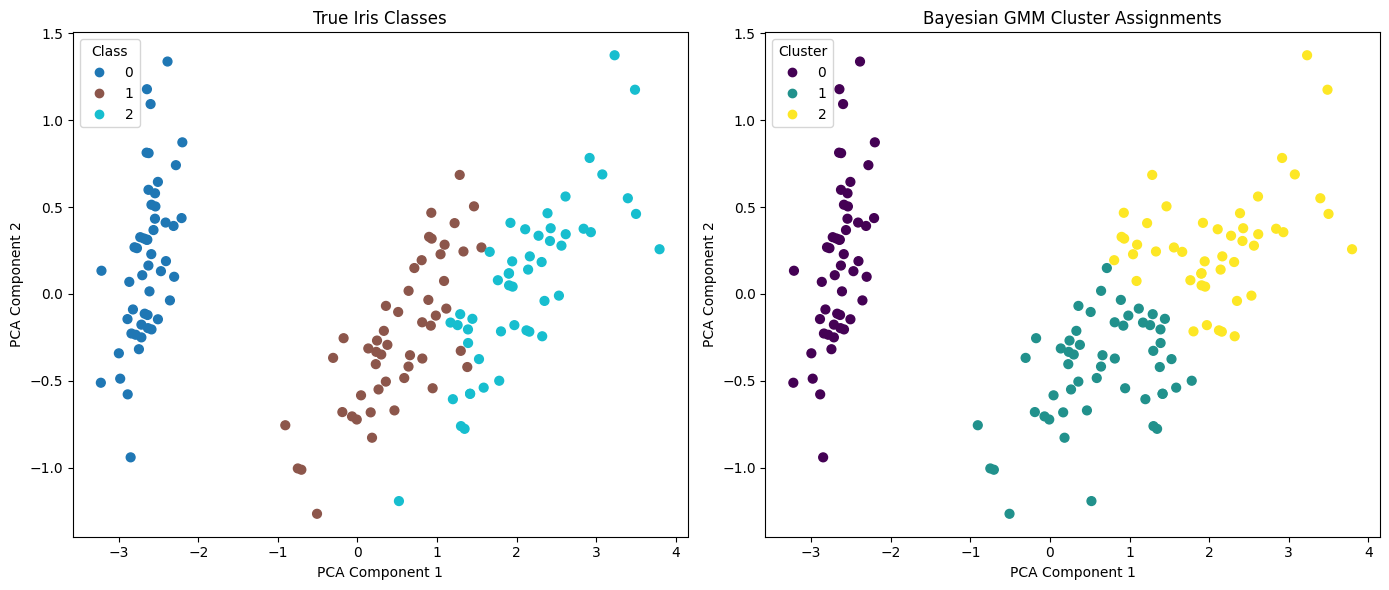

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left plot for true labels
scatter1 = axs[0].scatter(X_2d[:, 0], X_2d[:, 1], c=y_true, cmap='tab10', s=40)
axs[0].set_title("True Iris Classes")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")
axs[0].legend(*scatter1.legend_elements(), title="Class")

# Right plot for cluster assignments from Bayesian GMM
scatter2 = axs[1].scatter(X_2d[:, 0], X_2d[:, 1], c=final_assignments, cmap='viridis', s=40)
axs[1].set_title("Bayesian GMM Cluster Assignments")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")
axs[1].legend(*scatter2.legend_elements(), title="Cluster")

plt.tight_layout()
plt.show()

# Posterior Predictive for "unseen data"

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../src')
from bayesian_gaussian_mixture import bayesian_gaussian_mixture_clustering, posterior_predictive_cluster_assignment
from scipy.optimize import linear_sum_assignment

# Load Iris data
iris = load_iris()
X = iris.data
y = iris.target

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
# Bayesian GMM on training data
trace, cluster_assignments = bayesian_gaussian_mixture_clustering(
    X_train, n_components=3, draws=500, tune=500, chains=4, random_seed=42
)

Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [pi, mus, sigmas]
>CategoricalGibbsMetropolis: [category]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
/opt/anaconda3/envs/bnns/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
# Posterior predictive cluster assignment for test data
cluster_probs = posterior_predictive_cluster_assignment(trace, X_test)

In [16]:
# Align cluster labels across posterior samples before averaging

# Flatten posterior parameters
mus = trace.posterior['mus'].values  
mus = mus.reshape(-1, *mus.shape[-2:])  
S, K, D = mus.shape

# Choose reference ordering 
ref_order = np.argsort(mus[0, :, 0])
mus_ref = mus[0][ref_order]

# For each sample find best permutation to match reference means
perms = []
for s in range(S):
    cost = np.linalg.norm(mus[s][:, None, :] - mus_ref[None, :, :], axis=2) 
    r, c = linear_sum_assignment(cost) 
    perm = np.argsort(c) 
    perms.append(perm)
perms = np.array(perms)

# Permutations for cluster_probs per sample, then average
cluster_probs_aligned = np.empty_like(cluster_probs) 
for s in range(cluster_probs.shape[0]):
    cluster_probs_aligned[s] = cluster_probs[s][:, perms[s]]

mean_probs_aligned = cluster_probs_aligned.mean(axis=0) 
hard_assignments = mean_probs_aligned.argmax(axis=1)

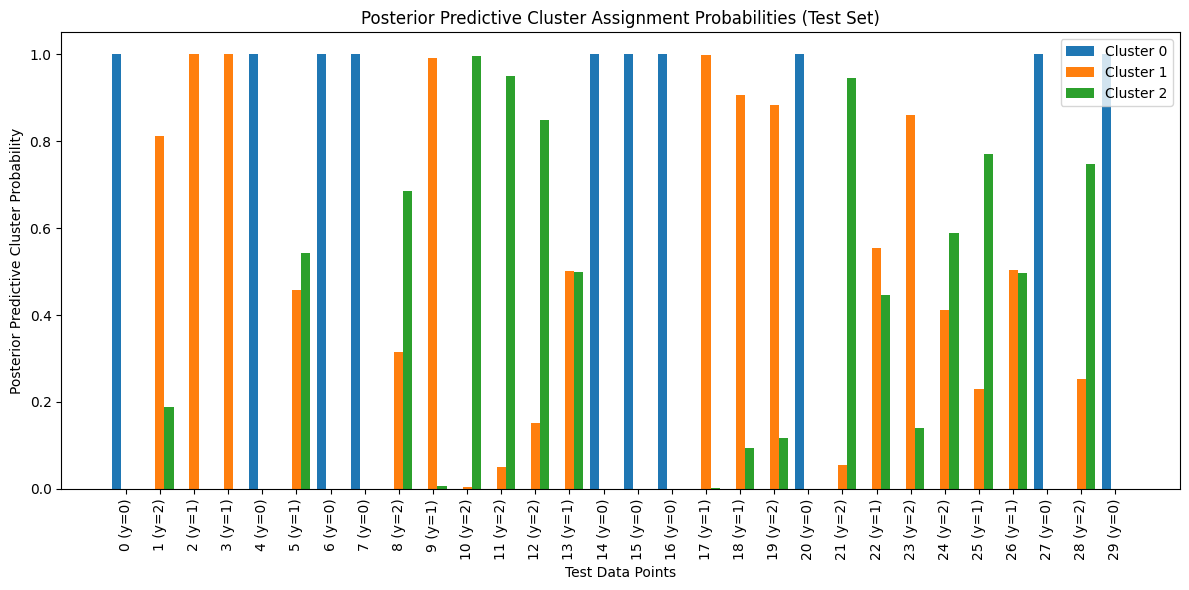

Most likely cluster assignments for test points: [0 1 1 1 0 2 0 0 2 1 2 2 2 1 0 0 0 1 1 1 0 2 1 1 2 2 1 0 2 0]
True labels: [0 2 1 1 0 1 0 0 2 1 2 2 2 1 0 0 0 1 1 2 0 2 1 2 2 1 1 0 2 0]


In [17]:
def plot_cluster_assignment_probs(mean_probs, y_true=None):
    n_new, n_components = mean_probs.shape
    x_labels = [f"Point {i}" for i in range(n_new)]
    cluster_labels = [f"Cluster {k}" for k in range(n_components)]

    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.8 / n_components  

    for k in range(n_components):
        ax.bar(
            np.arange(n_new) + k * width,
            mean_probs[:, k],
            width=width,
            label=cluster_labels[k]
        )

    ax.set_xticks(np.arange(n_new) + width * (n_components-1) / 2)
    if y_true is not None:
        ax.set_xticklabels([f"{i} (y={yt})" for i, yt in enumerate(y_true)], rotation=90)
    else:
        ax.set_xticklabels(x_labels, rotation=90)
    ax.set_xlabel("Test Data Points")
    ax.set_ylabel("Posterior Predictive Cluster Probability")
    ax.set_title("Posterior Predictive Cluster Assignment Probabilities (Test Set)")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot
plot_cluster_assignment_probs(mean_probs_aligned, y_test)

# Most likely cluster for each test point
most_likely = mean_probs_aligned.argmax(axis=1)
print("Most likely cluster assignments for test points:", most_likely)
print("True labels:", y_test)

In [18]:
# Get the most probable cluster assignment for each point (posterior mode) in training set
assignments_flat = cluster_assignments.reshape(-1, cluster_assignments.shape[-1])
final_assignments = mode(assignments_flat, axis=0).mode.flatten()

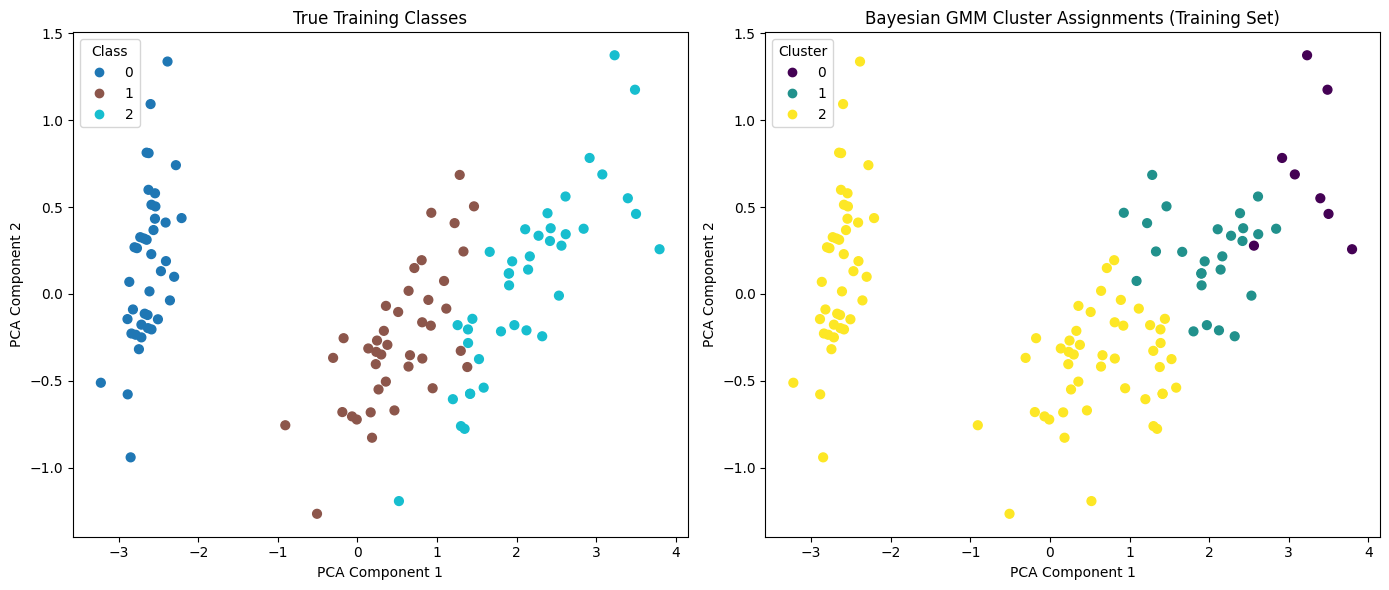

In [19]:
# Plot true training labels vs Bayesian GMM cluster assignments
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', s=40)
axs[0].set_title("True Training Classes")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")
axs[0].legend(*scatter1.legend_elements(), title="Class")

scatter2 = axs[1].scatter(X_train[:, 0], X_train[:, 1], c=final_assignments, cmap='viridis', s=40)
axs[1].set_title("Bayesian GMM Cluster Assignments (Training Set)")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")
axs[1].legend(*scatter2.legend_elements(), title="Cluster")

plt.tight_layout()
plt.show()

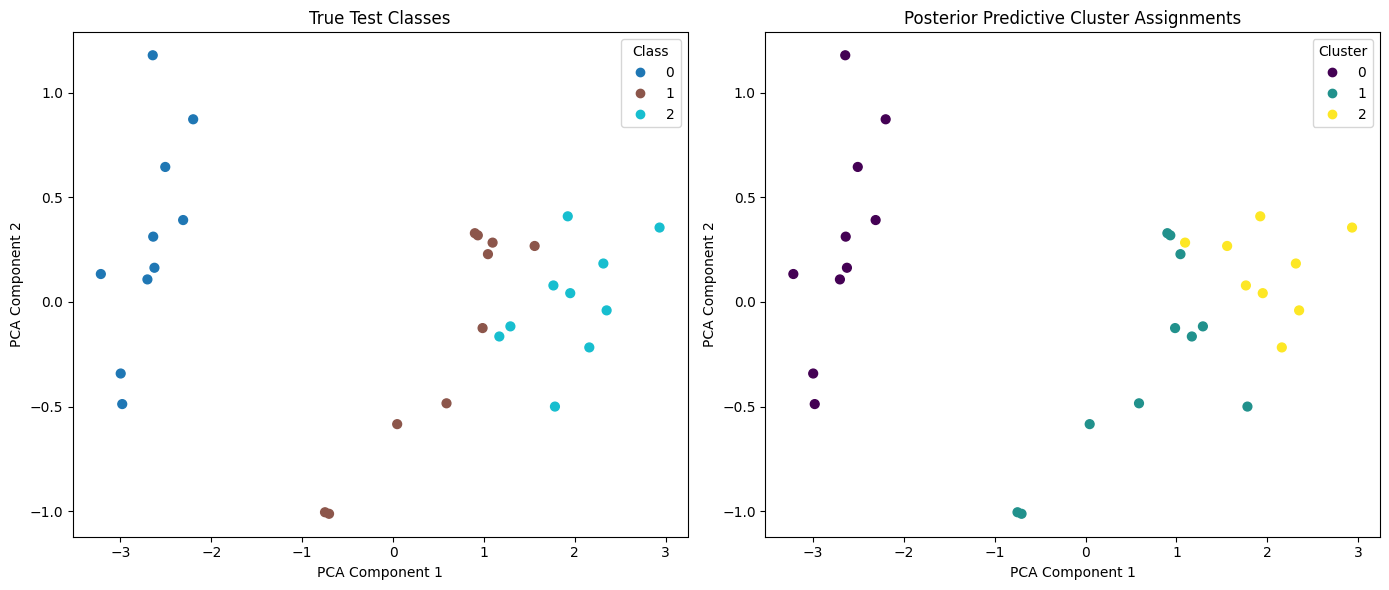

In [20]:
# Plot True test labels vs posterior predictive cluster Assignments
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: True test labels
scatter1 = axs[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='tab10', s=40)
axs[0].set_title("True Test Classes")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")
axs[0].legend(*scatter1.legend_elements(), title="Class")

# Right: Posterior predictive cluster assignments
scatter2 = axs[1].scatter(X_test[:, 0], X_test[:, 1], c=hard_assignments, cmap='viridis', s=40)
axs[1].set_title("Posterior Predictive Cluster Assignments")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")
axs[1].legend(*scatter2.legend_elements(), title="Cluster")

plt.tight_layout()
plt.show()